In [39]:
import json
import csv
import re
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim 
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from operator import itemgetter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Using some stopwords from https://github.com/AlludedCrabb/sound-tasty
cooking_stop_words = list(set([
        'canned', 'cans', 'drained', 'and', 'halved', 'cup', 'cups',
        'teaspoon', 'tablespoon', 'teaspoons', 'tablespoons',
        'finely', 'freshly', 'fresh', 'thickcut', 'to', 'taste',
        'grated', 'cut', 'into', 'wedges', 'pounds', 'unpeeled', 'large',
        'minced', 'slice', 'slices', 'sliced', 'thick-cut', 'cut',
        'crosswise', 'pieces', 'toothpicks', 'low-fat', 'chopped', 'or',
        'taste', 'cooked', 'dry', 'shredded', 'beaten', 'dried', 'melted',
        'stems', 'removed', 'diced', 'ounce', 'ounces', 'packages',
        'softened', 'such', 'RedHot®', 'RedHot', 'Franks', "Frank's",
        'crumbled', 'Old', 'Bay®', 'Bay', 'pinch', 'for', 'garnish', 'slice',
        'slices', 'needed', 'inch', 'cubes', 'cooking', 'spray', 'ground',
        'rotisserie', 'lowfat', 'as', 'quarteres', 'cloves', 'more', 'can',
        'package', 'frozen', 'thawed', 'packet', 'reducedfat', 'Knorr',
        'container', 'pound', 'peeled', 'deveined', 'seeded', 'ripe',
        'English', 'juiced', 'plus', 'more', 'Hass', 'cubed', 'Mexicanstyle',
        'hearts', 'prepared', 'party', 'pitted', 'mashed',
        'roma', 'optional', 'chunk', 'Hot', 'bunch', 'cleaned', 'box',
        'chickenflavored', 'Golden', 'delicious', 'cored', 'any', 'flavor',
        'flavored', 'whole', 'allpurpose', 'all', 'purpose', 'deep', 'frying',
        'dash', 'packed', 'in', 'French', 'jar', 'small', 'head', 'little',
        'smokie', 'seasoned', 'Boston', 'Bibb', 'leaves', 'lean', 'pickled',
        'Asian', 'dark', 'flaked', 'rolled', 'packed', 'jellied',
        'thirds', 'with', 'attached', 'skewers', 'skinless', 'boneless',
        'half', 'kernels', 'rinsed', 'quart', 'quarts', 'kernel',
        'Italianstyle', 'unpopped', 'lightly', 'coating', 'SAUCE',
        'lengthwise', 'miniature', 'semisweet', 'rinsed', 'round',
        'squeezed', 'stewed', 'raw', 'the', 'liquid', 'reserved', 'medium',
        'instant', 'solid', 'pack', 'refrigerated', 'halves', 'distilled',
        'loaf', 'extra', 'virgin', 'crushed', 'kosher', 'toasted', 'buttery',
        'TM', 'panko', 'Japanese', 'regular', 'bottle', 'bottles', 'thin',
        'peel', 'paper', 'thick', 'circles', 'unbleached',
        'breast', 'breasts', 'wings', 'strips', 'jumbo', 'giant', 'chunks',
        'quickcooking', 'sweetened', 'flakes', 'Ranchstyle', 'snipped',
        'food', 'ROTEL', 'Italian', 'sticks', 'stick', 'crescent', 'thinly',
        'boiled', 'Genoa', 'roasted', 'thin', 'extrasharp', 'pressed',
        'sifted', 'split', 'tips', 'discarded', 'mini', 'deli', 'drain',
        'reserve', 'diameter', 'Greek', 'Thai', 'drops', 'square', 'crusty',
        'American', 'selfrising', 'imitation', 'Wings', 'apart', 'at',
        'joints', 'wing', 'tips', 'discarded', 'parts',
        'tops', 'seperated', 'blend', 'coarsely', 'sweet', 'stalk', 'heads',
        'husked', 'divided', 'pats', 'unsalted', 'active', 'warm', 'sea',
        'separated', 'herb', 'overripe', 'degrees', 'F', 'C', 'room',
        'temperature', 'machine', 'very', 'pint', 'puree', 'coarse',
        'envelopes', 'lukewarm', 'creamstyle', 'unsweetened',
        'lite', 'of', 'chilled', 'freezer', 'cold', 'brushing', 'nonfat',
        'squares', 'tails', 'thigh', 'quarters', 'Masterpiece', 'KC', 'from',
        'El', 'Paso', 'bulk', 'Hunts', 'Roma', 'light', 'fluid', 'lagerstyle',
        'stalks', 'quartered', 'undrained', 'drained', 'Tony', 'Chacheres',
        'lump', 'uncooked', 'cube', 'bits', 'hair', 'angel', 'trimmed',
        'stew', 'spaghetti', 'brisket', 'bitesized', 'matchstick', 'Chobani',
        'unbaked', 'crust', 'torn', 'bonein', 'pounded', 'bitesize',
        'granules', 'boiling', 'yolk', 'coloring', 'pinch', 'a', 'blender',
        'fine', 'which', 'extralarge', 'use', 'will', 'make', 'garnish',
        'barely', 'moistened', 'about', 'right', 'before', 'serving', 'mix', 
        'thinly-sliced', 'thinly-sliced', 'etc', 'excess', 'granulated'
        ]))

unhelpful = list(set(['fresh', 'ripe', 'cracked', 'cooking', 'coarse', 'light', 
             'mild', 'hot', 'minced', 'dark roast', 'unsifted', 'canned', 
             'cans', 'drained', 'halved', 'finely', 'freshly', 'thickcut', 
             'grated', 'cut', 'unpeeled', 'large', 'minced', 'slice', 
             'slices', 'sliced', 'chopped','shredded', 'beaten', 'dried', 
             'melted', 'stems', 'softened', 'packages', 'crumbled', 'ground',
             'low-fat', 'rotisserie', 'lowfat', 'can', 'thawed', 'packet', 
             'reducedfat', 'small', 'pats', 'regular', 'lukewarm', 'mashed', 
             'stalk', 'breast', 'breasts', 'juiced', 'halves', 'extrasharp', 
             'sharp', 'extra sharp', 'frozen', 'raw', 'warm', 'divided', 
             'little', 'squares', 'thinly', 'thick', 'rinsed', 'toasted', 
             'bitesize', 'chunks', 'refrigerated', 'kernel', 'kernels', 
             'jar', 'lengthwise', 'unpeeled', 'cleaned', 'paper', 'melted', 
             'separated', 'seperated', 'deveined', 'party', 'bunch', 'overripe', 
             'boiled', 'chunk', 'container', 'bitesized', 'sweet', 'strips', 
             'sifted', 'roma', 'very', 'undrained', 'stewed', 'thawed', 'lean', 
             'roasted', 'extra', 'lite', 'coarsely', 'pressed', 'square', 
             'jumbo', 'yolk', 'yolks', 'barely', 'pitted', 'cored', 'puree', 
             'cubes', 'angel', 'hair', 'angelhair', 'giant', 'husked', 'chilled', 
             'thigh', 'trimmed', 'thin', 'lightly', 'cubed', 'drops', 'grated', 
             'boneless', 'unsalted', 'pieces', 'skinless', 'pounded', 
             'chickenflavored', 'extralarge', 'medium', 'reserve', 'unbaked', 
             'crushed', 'wings', 'crosswise', 'cold', 'bonein', 'bone in', 
             'squeezed', 'kosher', 'miniature', 'tails', 'quarters', 'attached', 
             'loaf', 'dry', 'more', 'head', 'removed', 'packed', 'hearts', 
             'matchstick', 'unbleached', 'heads', 'stems', 'sea', 'diced', 
             'mini', 'cut', 'unpopped', 'box', 'uncooked', 'freezer', 'stalks', 
             'shredded', 'halved', 'snipped', 'thick-cut', 'split', 'seeded', 
             'sweetened', 'discarded', 'lump', 'boiling', 'whole', 'semisweet', 
             'semi-sweet', 'quartered', 'moistened', 'reserved', 'prepared', 
             'fresh', 'ripe', 'cracked', 'cooking', 'coarse', 'light', 'mild', 
             'hot', 'minced', 'dark roast', 'unsifted', 'quaker', 'raw', 'frozen', 
             'calore-wise', 'ziploc bag', 'real', 'lite', 'crisp', 'decaffeinated', 
             'canned', 'processed', 'cooked', 'unpeeled', 'also', 'store-bought',]))

brands = ['rotel', 'absolut', 'betty crocker', 'jello', 'diana', 'ener-g', 
          'del-monte', "hunt's", 'martha', 'goya', 'cracker barrel', 
          'hamburger helper', "mccormick's", 'pepperidge farm', 'knorr', 
          'godiva', 'hidden valley', 'tabasco', 'branston', "kellogg's", 
          'hodgson mill', 'kraft', 'johnsonville', 'jim beam', 'mccormick', 
          'equal', 'jell-o', 'jimmy dean', 'country bob', "smucker's", 
          'toblerone', 'gerber', 'nestle', 'nestl', 'malt-o-meal', 'triscuit', 
          'ragu', 'campbell', 'hormel', 'earth balance', 'pillsbury', 
          "bird's eye", "campbell's", "betty crocker's", 'gold medal', 
          'crystal light', 'milnot', "land o' lakes", 'herb-ox', 'quaker',
          'coffee-mate', 'contadina', 'j&d', 'fantastic foods', 'bacardi', 
          'eckrich', 'little smokies', 'snickers', 'ortega', 'bayou blast', 
          "annie's", 'mrs. dash', 'mori-nu', 'old el paso', 'original supreme',
          'morton', 'nabisco', 'rice-a-roni', 'stolichnaya', "lawry's", 
          'st. germain', "eggland's best", 'club house "lagrille"', 'hostess',
          'giada de laurentiis genovese', '*available in most target stores', 
          'jarlsberg', 'pillsbury plus', 'ro-tel', 'pillsbury grands', 
          'shilling', 'hershey', 'hershey carb alternatives', 'pasta roni', 
          'pastaroni', 'torani', 'v8', 'v8 fusion', 'ghiradelli', 'oscar mayer',
          "bird's", 'smithfield', 'cadbury', 'sun-maid', 'karo', 
          'wishbone deluxe', 'vochelle', 'laughing cow', 'omega', 'stirrings',
          'duncan hines', 'barilla', 'carnation', 'bertolli', 'bertolli®',
          'breyers®', "1/2", "14.5", "''", "'s", "best®", "bell®", "bragg", 
          "crystal®", "crock®", "foods®", "frank's®", "gold®", "hellmann's®",
          "johnsonville®", "knorr®", "lipton®", "n't", "n", "pillsbury™", 
          "progresso™", "progresso", "ranch®", "secrets®", "valley®", "vay®",
          "yoplait®", "®", "’", 
         ]

measures = ['cup', 'cups', 'pound', 'pounds', 'teaspoon', 'tsp', 'teaspoons', 
            'tablespoon', 'tablespoons', 'tbs', 'ounce', 'ounces', 'oz', 'see', 
            'note', 'lb', 'lbs', '¼', '½', '⅓', '⅔']


stopwords_list = stopwords.words('english') + list(string.punctuation) + unhelpful\
                 + brands + measures
lemmatizer = WordNetLemmatizer()

In [4]:
filename = "../raw_data/recipes-en-201706/epicurious-recipes_m2.json"
with open(filename, 'r') as f:
    datastore = json.load(f)

In [11]:
datastore[0]['tag']['category']

'ingredient'

In [45]:
len(datastore)

34756

In [30]:
[(listing['tag']['category'], listing['tag']['name']) for listing in datastore[:0] if listing['tag']['category'] =='cuisine']

KeyError: 'tag'

In [33]:
all_with_cuisine = []
for listing in datastore:
    try: 
        if listing['tag']['category'] == 'cuisine':
            all_with_cuisine.append((listing['tag']['category'], listing['tag']['name']))
    except:
        pass

In [34]:
all_with_cuisine

[('cuisine', 'Italian'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'French'),
 ('cuisine', 'Italian'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'Asian'),
 ('cuisine', 'Cajun/Creole'),
 ('cuisine', 'Italian'),
 ('cuisine', 'American'),
 ('cuisine', 'French'),
 ('cuisine', 'American'),
 ('cuisine', 'Middle Eastern'),
 ('cuisine', 'Italian'),
 ('cuisine', 'Spanish/Portuguese'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'Jewish'),
 ('cuisine', 'American'),
 ('cuisine', 'Asian'),
 ('cuisine', 'African'),
 ('cuisine', 'Moroccan'),
 ('cuisine', 'Indian'),
 ('cuisine', 'Indian'),
 ('cuisine', 'American'),
 ('cuisine', 'American'),
 ('cuisine', 'Italian'),
 ('cuisine', 'Thai'),
 ('cuisine', 'Italian'),
 ('cuisine', 'American'),
 ('cuisine', 'French'),
 ('cuisine', 'African'),
 ('cuisine', 'Asian'),
 ('cuisine', 'American'),
 ('cuisine', 'Italian'),
 ('cuisine', 'Mexican'),
 ('cuisine', 'French'),
 ('cuisine', 'Asian'),
 ('cuisine', 'Italian'),
 ('cuisine', 'Fre

In [35]:
len(all_with_cuisine)

14847

In [36]:
all_cuisines = []
for listing in datastore:
    try: 
        if listing['tag']['category'] == 'cuisine':
            all_cuisines.append(listing['tag']['name'])
    except:
        pass

In [37]:
len(set(all_cuisines))

33

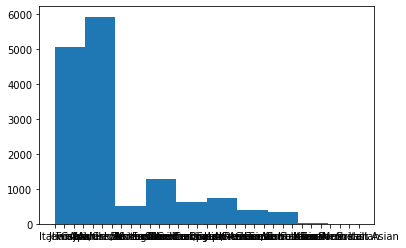

In [40]:
plt.hist(all_cuisines);

In [42]:
pd.Series(all_cuisines).value_counts()

American                      5480
Italian                       2121
French                        1294
Asian                         1268
Mexican                        809
Indian                         355
Jewish                         353
Mediterranean                  323
Spanish/Portuguese             307
Middle Eastern                 289
Greek                          284
English                        225
Central American/Caribbean     189
Eastern European/Russian       167
Central/South American         151
Southwestern                   150
Cajun/Creole                   144
Scandinavian                   131
Irish                          121
Thai                           120
Moroccan                       117
Chinese                        115
African                         92
Japanese                        90
German                          80
Vietnamese                      57
Latin American                   3
Tex-Mex                          3
Korean              

In [ ]:
url = datastore[0]['recipe']['url']

In [ ]:
[item['food'] for item in datastore[0]['recipe']['ingredients']]

In [ ]:
urls = []
labels = []
sources = []
ingreds = []

for recipe in datastore:
    recipe_path = recipe['recipe']
    urls.append(recipe_path['url'])
    labels.append(recipe_path['label'])
    sources.append(recipe_path['source'])
    ingreds.append([item['food'] for item in recipe_path['ingredients']])
    
all_recipes = {'url': urls,
               'label': labels, 
               'source': sources, 
               'ingredients': ingreds
              }

recipe_df = pd.DataFrame(all_recipes)

In [ ]:
recipe_df

In [ ]:
def isFloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

In [ ]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            return frac_str
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [ ]:
def tokenize_recipes(df):
    token_recipes = []
    for recipe in df['ingredients']:
        tokens = [word_tokenize(word) for word in recipe]
        flat_tkns = list(_flatten(tokens))
        stopped_tokens = [ w.lower() #re.search([0-9]+\/[0-9]+,
                          for w in flat_tkns 
                          if w not in stopwords_list 
                          if (isFloat(w) == False)]
        lemma_tokens = [lemmatizer.lemmatize(token) for token in stopped_tokens]
        token_recipes.append(lemma_tokens)
    return token_recipes

In [ ]:
def _flatten(list_of_lists):
    for x in list_of_lists:
        if hasattr(x, '__iter__') and not isinstance(x, str):
            for y in _flatten(x):
                yield y
        else:
            yield x

In [ ]:
all_ingreds = tokenize_recipes(recipe_df)
all_ingreds

In [ ]:
'bone' in(set(list(_flatten(all_ingreds))))

In [ ]:
list(_flatten(all_ingreds))

In [ ]:
test = set(all_ingreds[1]).intersection(_flatten(all_ingreds))
test

In [ ]:
isFloat('1/3')

In [ ]:
convert_to_float('1/3')

In [ ]:
for element in recipe_df['ingredients'][1]:
    print(re.search('[0-9]+\/[0-9]+', element.lower()))

In [ ]:
for element in recipe_df['ingredients'][1]:
    print(element)